In [19]:
import pandas
import numpy
import csv
import os
import warnings
from tqdm import tqdm
from functions import *

from pytest import skip

df_user_info = pandas.read_csv('user_list_more_than_20.csv')
df_anime_x = pandas.read_csv('top_and_bottom_anime.csv')
df_anime_y = pandas.read_csv('anime_matrix_true.csv')

#create main split for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_anime_x, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(X_train, y_train, test_size=0.2, random_state=720)

In [20]:
#Same spits are performed again to create df_true to check accuracy 
#create main split for training and testing
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split(df_anime_y, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
A_cross_train, A_cross_test, b_cross_train, b_cross_test = train_test_split(A_train, b_train, test_size=0.2, random_state=720)

df_true = A_cross_test.copy()

In [21]:
#create list of anime in test set 
test_anime = []
for i in range(len(X_cross_test)):
    test_anime.append(X_cross_test.iloc[i]['Id'].replace('\'',''))

In [10]:
#create user list
watch_values = y_cross_train.values
users = y_cross_train.columns[1:]

#create watch list based on df_anime_y
users_watched = []
for i in tqdm(range(len(users))):
    watched = []
    for j in range(len(watch_values)):
        if(watch_values[j][i+1]):
            watched.append(str(watch_values[j][0]))
    users_watched.append(watched)

#read each user's watch list and creates a bag of words of all anime they watched
user_bag_result = []
length = len(users)

for j in tqdm(range(length)):
    # user = df_mini_watch_list.loc[j]['user']
    watched = users_watched[j]
    bag = ''
    for k in range(len(watched)):
        if watched[k] not in test_anime:
            try:
                temp = '\'' + str(watched[k]) + '\''
                index = df_anime_x.loc[df_anime_x['Id'] == temp].index[0]
                bag += ' ' + Create_soup_selection(df_anime_x.loc[index],studio=False,source=True,genre=True,va=True)
            except:
                pass
    user_bag_result.append([users[j],bag])

#creates a bag of words for each anime
anime_bag_result = []
for i in tqdm(range(len(X_cross_test))):
    anime = X_cross_test.iloc[i]['Id'].replace('\'','')
    bag = Create_soup_selection(X_cross_test.iloc[i],studio=True,source=True,genre=True,va=False)
    anime_bag_result.append([anime,bag])

#output the user bag of words to csv
outputdf = pandas.DataFrame(user_bag_result, columns=['user','bag of words'])
outputdf.to_csv('users_bag_of_words_drop_studio.csv', index=False)

#output the anime bag of words to csv
outputdf = pandas.DataFrame(anime_bag_result, columns=['Id','bag of words'])
outputdf.to_csv('anime_bag_of_words__drop_va.csv', index=False)

100%|██████████| 89/89 [00:00<00:00, 8056.05it/s]


In [40]:
#Creates similarity matrix of all anime for all users
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_user_bag = pandas.read_csv('users_bag_of_words_drop_va.csv')
df_anime_bag = pandas.read_csv('anime_bag_of_words_drop_va.csv')

count = CountVectorizer()
df_similarity = pandas.DataFrame()
df_similarity = df_true[['Id']].copy()
users = df_true.columns[1:]

for i in tqdm(range(len(users))):
    list_of_bag_of_words = [df_user_bag.loc[i]['bag of words']]

    count_matrix = count.fit_transform(df_anime_bag['bag of words'])
    try:
        count_matrix2 = count.transform(list_of_bag_of_words)
    except:
        #if user has an empty bag give them a matix of zeros
        count_matrix2 = count.transform(['a'])

    cosine_sim2 = cosine_similarity(count_matrix, count_matrix2)
    # sim_scores = list(enumerate(cosine_sim2))
    sim_scores = []
    for each in cosine_sim2:
        sim_scores.append(each[0])
    warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
    df_similarity[users[i]] = sim_scores

# print(sim_scores[1][1][0])


100%|██████████| 9028/9028 [00:18<00:00, 493.83it/s]


In [27]:
import pickle

file = open('similarity_matrix.p', 'wb')
pickle.dump(df_similarity,file)

In [6]:
import pickle

file = open('similarity_matrix.p', 'rb')
df_similarity = pickle.load(file)

In [13]:
labels = ['all','drop va','drop genre','drop source', 'drop studio']
pos_sim_avg = []
neg_sim_avg = []

In [34]:
#write code to traverse matrix and find the average sim score for 1's and 0's
sim_val = df_similarity.values
watch_val = df_true.values
user_list = df_similarity.columns
sim_score_pos = []
sim_score_neg = []

for i in tqdm(range(len(sim_val))):
    for j in range(1,len(user_list)):    #skip the first item b/c that is the anime id
        if watch_val[i][j] == 1:
            sim_score_pos.append(sim_val[i][j])
        else:
            sim_score_neg.append(sim_val[i][j])

pos_sim_avg.append(sum(sim_score_pos) / len(sim_score_pos))
neg_sim_avg.append(sum(sim_score_neg) / len(sim_score_neg))

100%|██████████| 89/89 [00:00<00:00, 296.24it/s]


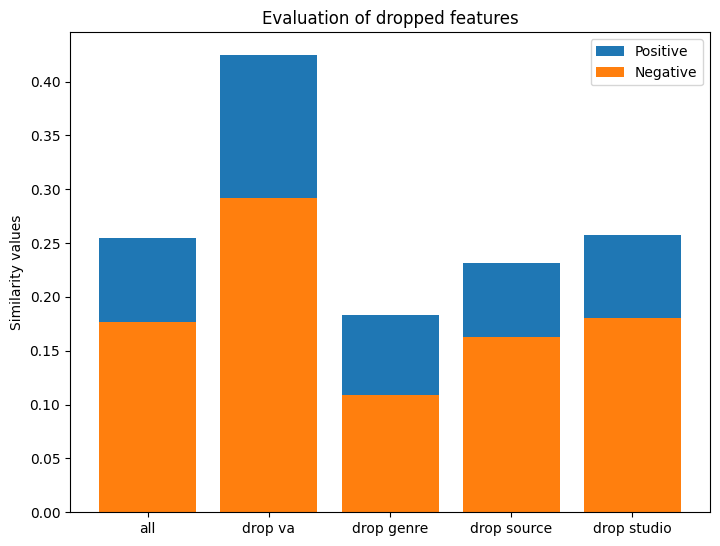

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# plt.ylim(0.75,0.85)

ax.bar(labels,pos_sim_avg, label = 'Positive')
ax.bar(labels,neg_sim_avg, label = 'Negative')

ax.set_ylabel('Similarity values')
ax.set_title('Evaluation of dropped features')
plt.legend()
plt.show()

In [41]:
#write code to traverse matrix and find the average sim score for 1's and 0's
sim_val = df_similarity.values
watch_val = df_true.values
user_list = df_similarity.columns
sim_score_pos = []
sim_score_neg = []

for i in tqdm(range(len(sim_val))):
    for j in range(1,len(user_list)):    #skip the first item b/c that is the anime id
        if watch_val[i][j] == 1:
            sim_score_pos.append(sim_val[i][j])
        else:
            sim_score_neg.append(sim_val[i][j])

print(f'Average similarity for watched anime: {sum(sim_score_pos) / len(sim_score_pos): .4f}')
print(f'Average similarity for not watched: {sum(sim_score_neg) / len(sim_score_neg): .4f}')

100%|██████████| 89/89 [00:00<00:00, 287.73it/s]

Average similarity for watched anime:  0.4245
Average similarity for not watched:  0.2915


In [45]:
#Make predictions with different intervals
similarity_interval = [0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47]

for i in tqdm(range(len(similarity_interval))):
    predictions = []
    for k in range(len(sim_val)):
        prediction_row = [sim_val[k][0]]
        for j in range(1,len(sim_val[k])):    #skip the first time b/c that is the anime Id
            if sim_val[k][j] >= similarity_interval[i]:
                prediction_row.append(1)
            else: 
                prediction_row.append(0)
        predictions.append(prediction_row)
    string_val = str(similarity_interval[i]).replace('.','')
    outputdf = pandas.DataFrame(predictions, columns=user_list)
    outputdf.to_csv(f'items2items_sim_val_{string_val}.csv', index=False)


100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


In [42]:
#Finds the avegrage similarity watch values for each user
sim_val = df_similarity.values
watch_val = df_true.values
user_list = df_similarity.columns
user_similiarties = []
row = len(watch_val)
col = len(watch_val[0])

for i in tqdm(range(1,col)):  #first column is anime Id
    similarities = []
    for j in range(row):
        if watch_val[j][i] == 1:
            similarities.append(sim_val[j][i])
    try:
        user_similiarties.append(sum(similarities) / len(similarities))
    except:
        user_similiarties.append(0)

100%|██████████| 9028/9028 [00:00<00:00, 50098.73it/s]


In [43]:
sim_val = df_similarity.values
row = len(sim_val)
col = len(sim_val[0])
prediction_result = []
factor = 1.0

for i in range(row):
    prediction = [sim_val[i][0]]
    for j in range(1,col):                                         #skip first item b/c it's anime ID
        if sim_val[i][j] >= (user_similiarties[j-1] * factor):     #user_similiarties is off by one b/c it does not have anime ID
            prediction.append(1)
        else:
            prediction.append(0)
    prediction_result.append(prediction)

outputdf = pandas.DataFrame(prediction_result, columns=user_list)
outputdf.to_csv(f'items2items_sim_variable.csv', index=False)

In [44]:
#caluclate accuracy
correct = 0
prediction_matrix = pandas.read_csv('items2items_sim_variable.csv')
pred_values = prediction_matrix.values
true_values = df_true.values
predict_watch = 0
true_watch = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
null = 0

num_row = len(pred_values)
num_col = len(pred_values[0])
for i in tqdm(range(num_row)):
    for j in range(1,num_col):          #first item is the anime id, so we skip it
        if pred_values[i,j] == true_values[i,j]:
            correct += 1
        if pred_values[i,j] == 1:
            predict_watch += 1
            if true_values[i,j] == 1:
                true_pos += 1
                true_watch += 1
            else:
                false_pos += 1

        if pred_values[i,j] == 0:
            if true_values[i,j] == 0:
                true_neg += 1
            else:
                false_neg += 1
                true_watch += 1

        if 0 == true_values[i,j]:
            null += 1
        

#subtracting 1 from column length b/c the first item is the anime id
percent = (correct / ((num_row) * (num_col-1)))
total = (num_row) * (num_col-1)
print(f'Total predictions: {total}')
print(f'Correct predictions: {correct}')

print(f'Predicted watch: {predict_watch}')
print(f'True watched: {true_watch}')
print(f'True positive: {true_pos}')
print(f'True negative: {true_neg}')
print(f'False negative: {false_neg}')
print(f'Null Error Rate: {(null / total)*100: .2f}')
print(f'False positive: {false_pos}')
print(f'Percent correct: {percent * 100: .2f}%')
print(f'Precision: {(true_pos / (true_pos + false_pos)): .2f}')
print(f'Recall: {(true_pos / (true_pos + false_neg)): .2f}')

100%|██████████| 89/89 [00:00<00:00, 150.70it/s]

Total predictions: 803492
Correct predictions: 597093
Predicted watch: 167175
True watched: 171942
True positive: 66359
True negative: 530734
False negative: 105583
Null Error Rate:  78.60
False positive: 100816
Percent correct:  74.31%
Precision:  0.40
Recall:  0.39


In [46]:
#caluclate accuracy
percent_values = []
precision_values = []
recall_values = []
f1_values = []
for i in range(len(similarity_interval)):
    string_val = str(similarity_interval[i]).replace('.','')
    correct = 0
    prediction_matrix = pandas.read_csv(f'items2items_sim_val_{string_val}.csv')
    pred_values = prediction_matrix.values
    true_values = df_true.values
    predict_watch = 0
    true_watch = 0
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    null = 0

    num_row = len(pred_values)
    num_col = len(pred_values[0])
    for i in (range(num_row)):
        for j in range(1,num_col):          #first item is the anime id, so we skip it
            if pred_values[i,j] == true_values[i,j]:
                correct += 1
            if pred_values[i,j] == 1:
                predict_watch += 1
                if true_values[i,j] == 1:
                    true_pos += 1
                    true_watch += 1
                else:
                    false_pos += 1

            if pred_values[i,j] == 0:
                if true_values[i,j] == 0:
                    true_neg += 1
                else:
                    false_neg += 1
                    true_watch += 1

            if 0 == true_values[i,j]:
                null += 1
            

    #subtracting 1 from column length b/c the first item is the anime id
    percent = (correct / ((num_row) * (num_col-1)))
    precision = (true_pos / (true_pos + false_pos))
    recall = (true_pos / (true_pos + false_neg))
    f1 = (2*precision*recall) / (precision + recall)
    total = (num_row) * (num_col-1)
    percent_values.append(percent)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)
# print(f'Total predictions: {total}')
# print(f'Correct predictions: {correct}')

# print(f'Predicted watch: {predict_watch}')
# print(f'True watched: {true_watch}')
# print(f'True positive: {true_pos}')
# print(f'True negative: {true_neg}')
# print(f'False negative: {false_neg}')
# print(f'Null Error Rate: {(null / total)*100: .2f}')
# print(f'False positive: {false_pos}')
# print(f'Percent correct: {percent * 100: .2f}%')
# print(f'Precision: {(true_pos / (true_pos + false_pos)): .2f}')
# print(f'Recall: {(true_pos / (true_pos + false_neg)): .2f}')

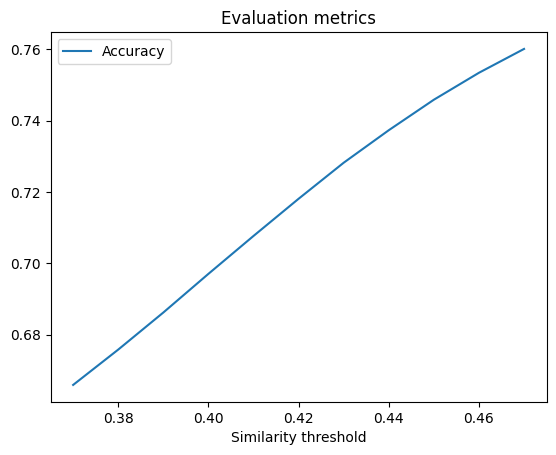

In [47]:
import matplotlib.pyplot as plt

plt.plot(similarity_interval,percent_values, label = 'Accuracy')
plt.title('Evaluation metrics')
plt.xlabel('Similarity threshold')
plt.legend()
plt.show()

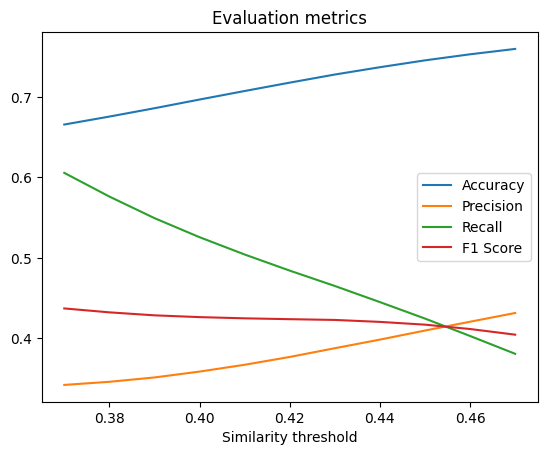

In [48]:
import matplotlib.pyplot as plt

plt.plot(similarity_interval,percent_values, label = 'Accuracy')
plt.plot(similarity_interval,precision_values, label = 'Precision')
plt.plot(similarity_interval,recall_values, label = 'Recall')
plt.plot(similarity_interval,f1_values, label = 'F1 Score')
plt.title('Evaluation metrics')
# plt.ylabel('Accuracy %')
plt.xlabel('Similarity threshold')
plt.legend()
plt.show()

In [56]:
#caluclate accuracy
correct = 0
prediction_matrix = pandas.read_csv('items2items_sim_val_041.csv')
pred_values = prediction_matrix.values
true_values = df_true.values
predict_watch = 0
true_watch = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
null = 0

num_row = len(pred_values)
num_col = len(pred_values[0])
for i in tqdm(range(num_row)):
    for j in range(1,num_col):          #first item is the anime id, so we skip it
        if pred_values[i,j] == true_values[i,j]:
            correct += 1
        if pred_values[i,j] == 1:
            predict_watch += 1
            if true_values[i,j] == 1:
                true_pos += 1
                true_watch += 1
            else:
                false_pos += 1

        if pred_values[i,j] == 0:
            if true_values[i,j] == 0:
                true_neg += 1
            else:
                false_neg += 1
                true_watch += 1

        if 0 == true_values[i,j]:
            null += 1
        

#subtracting 1 from column length b/c the first item is the anime id
percent = (correct / ((num_row) * (num_col-1)))
total = (num_row) * (num_col-1)
print(f'Total predictions: {total}')
print(f'Correct predictions: {correct}')

print(f'Predicted watch: {predict_watch}')
print(f'True watched: {true_watch}')
print(f'True positive: {true_pos}')
print(f'True negative: {true_neg}')
print(f'False negative: {false_neg}')
print(f'Null Error Rate: {(null / total)*100: .2f}')
print(f'False positive: {false_pos}')
print(f'Percent correct: {percent * 100: .2f}%')
print(f'Precision: {(true_pos / (true_pos + false_pos)): .2f}')
print(f'Recall: {(true_pos / (true_pos + false_neg)): .2f}')

100%|██████████| 89/89 [00:00<00:00, 144.79it/s]

Total predictions: 803492
Correct predictions: 568603
Predicted watch: 236305
True watched: 171942
True positive: 86679
True negative: 481924
False negative: 85263
Null Error Rate:  78.60
False positive: 149626
Percent correct:  70.77%
Precision:  0.37
Recall:  0.50


C:\Users\Tenkawa PC\AppData\Local\Temp\ipykernel_6476\678633288.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot()


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

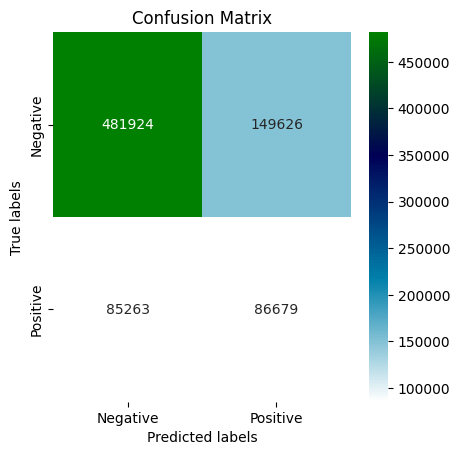

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

#have to convert true_values and pred_values from matrix to list
y_true = []
y_pred = []
for i in range(len(true_values)):
    y_true += list(true_values[i][1:])
    y_pred += list(pred_values[i][1:])

cm = confusion_matrix(y_true,y_pred)
plt.matshow(cm)

   

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='ocean_r');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f'Accuray: {accuracy_score(y_true, y_pred):.2f}')
print(f'Precision: {precision_score(y_true, y_pred):.2f}')
print(f'Recall: {recall_score(y_true, y_pred):.2f}')
print(f'F1 score: {f1_score(y_true, y_pred):.2f}')

Accuray: 0.71
Precision: 0.37
Recall: 0.50
F1 score: 0.42
